# Drug Classfication Based on Sentiment Analysis Review (Druglib.com)
## Case Study:

The number of medicinal products circulating in pharmacies causes consumers to compare the product with other products. The machine learning model that is built is expected to be able to provide product classfication based on the types of complaints experienced by consumers or the products they want to find. Drug classfication are obtained from a collection of reviews related to preferences and conditions, effectiveness, reviews, and product ratings from review data on Druglib.com. The drug review will then be analyzed further using sentiment analysis with an algorithm model from long short-term memory (LSTM).

## Data Set Information:

The dataset provides patient reviews on specific drugs along with related conditions. Furthermore, reviews are grouped into reports on the three aspects benefits, side effects and overall comment. Additionally, ratings are available concerning overall satisfaction as well as a 5 step side effect rating and a 5 step effectiveness rating. The data was obtained by crawling online pharmaceutical review sites. The intention was to study

1. sentiment analysis of drug experience over multiple facets, i.e. sentiments learned on specific aspects such as effectiveness and side effects,
2. the transferability of models among domains, i.e. conditions, and
3. the transferability of models among different data sources (see 'Drug Review Dataset (Drugs.com)').

The data is split into a train (75%) a test (25%) partition (see publication) and stored in two .tsv (tab-separated-values) files, respectively.

## Informasi Atribut:

1. urlNama Obat (kategoris): nama obat
2. kondisi (kategoris): nama kondisi
3. manfaatReview (teks): pasien tentang manfaat
4. Efek sampingReview (teks): pasien tentang efek samping
5. komentarReview (teks): pasien secara keseluruhan komentar
6. peringkat (numerik): peringkat pasien bintang 10
7. Efek samping (kategoris): peringkat efek samping 5 langkah
8. efektivitas (kategoris): peringkat efektivitas 5 langkah

Source dataset: [Drug Review Dataset (Druglib.com)](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Druglib.com%29)

#### Import Library

In [1]:
import tensorflow as tf 
print(tf.__version__)

2.8.0


In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [281]:
import os
import zipfile
import wordcloud as ws
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from sklearn import preprocessing
from textblob import Word
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping

In [17]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


#### Import Dataset

In [5]:
!wget --no-check-certificate \
  https://archive.ics.uci.edu/ml/machine-learning-databases/00461/drugLib_raw.zip \
  -O /tmp/drugLib_raw.zip

--2022-05-13 22:00:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/00461/drugLib_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1133354 (1.1M) [application/x-httpd-php]
Saving to: ‘/tmp/drugLib_raw.zip’

/tmp/drugLib_raw.zi 100%[===================>]   1.08M  1.06MB/s    in 1.0s    

2022-05-13 22:00:39 (1.06 MB/s) - ‘/tmp/drugLib_raw.zip’ saved [1133354/1133354]



In [6]:
local_zip = '/tmp/drugLib_raw.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/drugLib_raw')
zip_ref.close()
base_dir = '/tmp/drugLib_raw/'

#### Import pre-trained word embeddings

In [7]:
!wget --no-check-certificate \
  http://nlp.stanford.edu/data/glove.6B.zip \
  -O /tmp/glove.6B.zip

--2022-05-13 22:00:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-13 22:00:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-13 22:00:48--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’

/t

In [8]:
local_zip = '/tmp/glove.6B.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/glove')
zip_ref.close()
pretrained_dir = '/tmp/glove/'


#### Exploring Data

##### Convert Dataset into pandas

In [9]:
# Import dataset train and test to pandas
df_train = pd.read_csv(os.path.join(base_dir, 'drugLibTrain_raw.tsv'), sep='\t')
df_test = pd.read_csv(os.path.join(base_dir, 'drugLibTest_raw.tsv'), sep='\t')

# merge dataset train and test
df_all = pd.concat([df_train.iloc[:, 1:], df_test.iloc[:, 1:]], sort=True).reset_index(drop=True)

display(df_all.head())
print('Dataset Shape : {}'.format(df_all.shape))
print('Dataset columns : {}'.format(df_all.columns.values))

,benefitsReview,commentsReview,condition,effectiveness,rating,sideEffects,sideEffectsReview,urlDrugName
0,slowed the progression of left ventricular dys...,"monitor blood pressure , weight and asses for ...",management of congestive heart failure,Highly Effective,4,Mild Side Effects,"cough, hypotension , proteinuria, impotence , ...",enalapril
1,Although this type of birth control has more c...,"I Hate This Birth Control, I Would Not Suggest...",birth prevention,Highly Effective,1,Severe Side Effects,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...",ortho-tri-cyclen
2,I was used to having cramps so badly that they...,I took 2 pills at the onset of my menstrual cr...,menstrual cramps,Highly Effective,10,No Side Effects,Heavier bleeding and clotting than normal.,ponstel
3,The acid reflux went away for a few months aft...,I was given Prilosec prescription at a dose of...,acid reflux,Marginally Effective,3,Mild Side Effects,"Constipation, dry mouth and some mild dizzines...",prilosec
4,I think that the Lyrica was starting to help w...,See above,fibromyalgia,Marginally Effective,2,Severe Side Effects,I felt extremely drugged and dopey. Could not...,lyrica


Dataset Shape : (4143, 8)
Dataset columns : ['benefitsReview' 'commentsReview' 'condition' 'effectiveness' 'rating'
 'sideEffects' 'sideEffectsReview' 'urlDrugName']


##### Check Missing Value

In [10]:
df_all.isnull().sum()

benefitsReview       0
commentsReview       8
condition            1
effectiveness        0
rating               0
sideEffects          0
sideEffectsReview    2
urlDrugName          0
dtype: int64

In [11]:
df_all.loc[df_all.isnull().any(axis=1)]

,benefitsReview,commentsReview,condition,effectiveness,rating,sideEffects,sideEffectsReview,urlDrugName
147,Treatment cleared up the infection.,NaN,epididymitus,Moderately Effective,4,Severe Side Effects,Treatment ended 2 months ago and have still go...,doxycycline
400,Pills helped to lower my blood pressure. Also...,NaN,hypertension,Highly Effective,8,Moderate Side Effects,"Back pain, especially after a missed dose. In...",hyzaar
407,This medication enabled me to think clearly. ...,NaN,adhd,Considerably Effective,8,Mild Side Effects,"This medication caused me to be nervous, tremb...",ritalin-la
1238,Experienced 1 migrane in the past year since o...,NaN,prevent menstral migranes,Highly Effective,9,Mild Side Effects,Noticed light skin iritation. Take the light ...,seasonique
1468,preventing pregnancy,NaN,preventing pregnancy,Considerably Effective,4,Moderate Side Effects,This pill was great b/c i didn't have any peri...,seasonique
1965,i have been on xenical for a little over 2 wee...,NaN,over weight,Marginally Effective,3,No Side Effects,i dont have any other then now i am constipated,xenical
2402,balancing of thyroid back to normal range. Pri...,.1mg daily orally.,thyroid,Highly Effective,10,No Side Effects,NaN,levothroid
2488,None. I had a bacterial infection accompanyin...,Absoutely innefective. I easily could have be...,NaN,Ineffective,2,No Side Effects,The only good point I suppose is that there wa...,keflex
2705,cleared up nose,NaN,plugged up nose related to seasonal allergies,Considerably Effective,8,No Side Effects,none,flonase
2891,Controlled acne breakouts to some extent when ...,Took Doxylin 50 mg once daily for 3 months. I...,acne,Moderately Effective,6,No Side Effects,NaN,doxycycline


##### Fill in Missing Value
In the Condition column included in the keflex product, fill in the infection value, as this product is frequently used for infection, and data containing other missing values will be removed because the data are owned by different reviewers


In [12]:
df_all['condition'] = df_all['condition'].fillna('infection')
df_all.dropna(axis=0, subset=['commentsReview', 'sideEffectsReview'], inplace=True)
df_all.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4133 entries, 0 to 4142
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   benefitsReview     4133 non-null   object
 1   commentsReview     4133 non-null   object
 2   condition          4133 non-null   object
 3   effectiveness      4133 non-null   object
 4   rating             4133 non-null   int64 
 5   sideEffects        4133 non-null   object
 6   sideEffectsReview  4133 non-null   object
 7   urlDrugName        4133 non-null   object
dtypes: int64(1), object(7)

##### Data Visualization

Text(0.5, 1.0, 'Count values of rating')

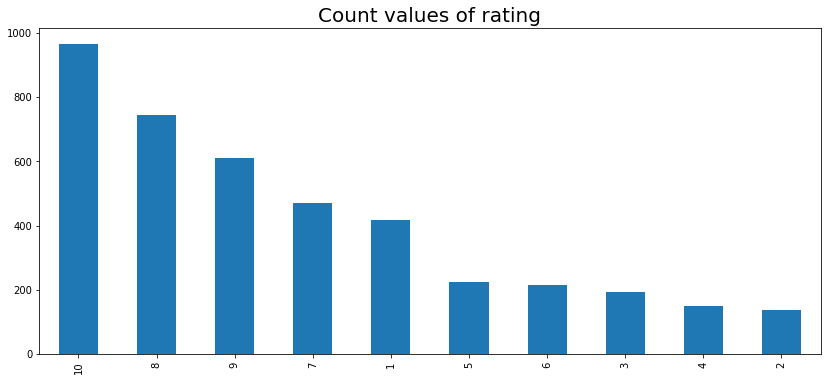

In [13]:
rating = df_all['rating'].value_counts()
rating.plot(kind='bar', figsize=(14,6))
plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.title('Count values of rating', fontsize=20)

#### Feature Engineering

##### Stopword Remove

In [266]:
english_stops = set(stopwords.words('english'))

#merge columns review
df_all['review'] = df_all['condition'] + df_all['commentsReview'] + df_all['benefitsReview'] + df_all['sideEffectsReview'] + df_all['sideEffects']
df_all['review'] = df_all['review'].replace({'<.*?>': ''}, regex = True) # remove html tag
df_all['review'] = df_all['review'].replace({'[^A-Za-z]': ' '}, regex = True) # remove non alphabet
df_all['review'] = df_all['review'].replace({'\s+[a-zA-Z]\s+': ' '}, regex = True) # Single character removal
df_all['review'] = df_all['review'].replace({'\s+': ' '}, regex = True) # Replacing the digits/numbers

df_all['review'] = df_all['review'].apply(lambda review: [w for w in review.split() if w not in english_stops]) # remove stop words
df_all['review'] = df_all['review'].apply(lambda review: [Word(w).lemmatize() for w in review]) # lemmatize
df_all['review'] = df_all['review'].apply(lambda review: [w.lower() for w in review]) # lower case  

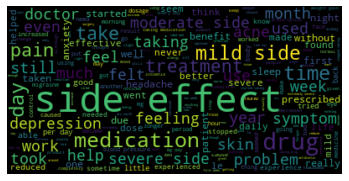

In [267]:
common_words=''
for x,i in enumerate(df_all.review):
    common_words += ' '.join(i)+' '
wordcloud = ws.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### Encoding

In [63]:
# encode rating
df_all['rating_reviews'] = df_all['rating'].apply(lambda x: 'netral' if x > 3 and x < 6 else 'negatif' if x < 3 else 'positif')
encode = pd.get_dummies(df_all['rating_reviews'])

dfs = pd.concat([df_all, encode], axis=1)
dfs = dfs.drop(columns=['commentsReview', 'benefitsReview', 'sideEffectsReview'])

feature = dfs['review'].values
target = dfs[encode.columns].values

##### Train Test Split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2)

In [65]:
def get_max_length():
    review_length = []
    for review in X_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

##### Tokenizer

In [66]:
tokenizer = Tokenizer(lower=False, oov_token='-')
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
 
sekuens_train = tokenizer.texts_to_sequences(X_train)
sekuens_test = tokenizer.texts_to_sequences(X_test)

max_length = get_max_length()

padded_train = pad_sequences(sekuens_train, maxlen=max_length, padding='post', truncating='post')
padded_test = pad_sequences(sekuens_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(tokenizer.word_index) + 1

##### pre-trained word embeddings

In [274]:
path_to_glove_file = os.path.join(
    pretrained_dir, 'glove.6B.100d.txt'
)

embeddings_index = dict()
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [275]:
embedding_matrix = np.zeros((total_words, 100))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#### Build Model

In [230]:
def plot(val_train, val_test, title):
  plt.plot(val_train)
  plt.plot(val_test)
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

###### GridSearchCV

In [235]:
from keras import backend as backend
def create_model(unit=128, LSTM_OUT=64, optimizer='adam'):
    backend.clear_session()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(total_words, EMBED_DIM, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(tf.keras.layers.SpatialDropout1D(0.2))
    model.add(tf.keras.layers.LSTM(LSTM_OUT, return_sequences=True))
    model.add(tf.keras.layers.Dense(unit, activation='relu'))
    model.add(tf.keras.layers.LSTM(LSTM_OUT))
    model.add(tf.keras.layers.Dense(unit, activation='relu'))
    model.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [242]:
model = KerasClassifier(build_fn=create_model, batch_size=64, verbose=1)

params = {
    'optimizer': ['Adam', 'sgd'],
    }
grid_result = GridSearchCV(estimator=model, param_grid=params, cv=3)
grid_result = grid_result.fit(padded_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


26/26 [==============================] - 3s 16ms/step - loss: 0.7615 - accuracy: 0.7638


In [243]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.780399 using {'optimizer': 'Adam'}
0.780399 (0.013171) with: {'optimizer': 'Adam'}
0.780399 (0.013171) with: {'optimizer': 'sgd'}


In [293]:
EMBED_DIM = 100
LSTM_OUT = 64

num_epochs = 100
num_batch_size = 64
callbacks = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=5, 
                   restore_best_weights=True)

In [294]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, EMBED_DIM, weights=[embedding_matrix], input_length=max_length, trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])
model.summary()
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 70, 100)           1851900   
                                                                 
 bidirectional_18 (Bidirecti  (None, 70, 256)          234496    
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 70, 128)          164352    
 onal)                                                           
                                                                 
 bidirectional_20 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_42 (Dense)            (None, 16)                1040      
                                                     

In [295]:
history1 = model.fit(padded_train, y_train, batch_size=num_batch_size, epochs=100, 
                    validation_data=(padded_test, y_test), verbose=1, callbacks=[callbacks])

Epoch 1/100
52/52 [==============================] - 11s 70ms/step - loss: 0.7097 - accuracy: 0.7665 - val_loss: 0.7363 - val_accuracy: 0.7533
Epoch 2/100
52/52 [==============================] - 2s 33ms/step - loss: 0.6742 - accuracy: 0.7804 - val_loss: 0.7393 - val_accuracy: 0.7533
Epoch 3/100
52/52 [==============================] - 2s 33ms/step - loss: 0.6709 - accuracy: 0.7804 - val_loss: 0.6963 - val_accuracy: 0.7533
Epoch 4/100
52/52 [==============================] - 2s 33ms/step - loss: 0.6359 - accuracy: 0.7868 - val_loss: 0.6330 - val_accuracy: 0.7932
Epoch 5/100
52/52 [==============================] - 2s 34ms/step - loss: 0.5797 - accuracy: 0.8007 - val_loss: 0.6248 - val_accuracy: 0.8029
Epoch 6/100
52/52 [==============================] - 2s 32ms/step - loss: 0.5527 - accuracy: 0.8131 - val_loss: 0.6126 - val_accuracy: 0.7993
Epoch 7/100
52/52 [==============================] - 2s 33ms/step - loss: 0.5352 - accuracy: 0.8224 - val_loss: 0.6318 - val_accuracy: 0.7848
Epoch

###### Plot Accuracy

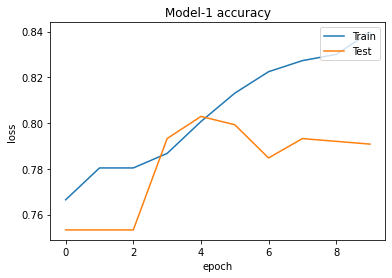

In [296]:
plot(history1.history['accuracy'], history1.history['val_accuracy'], 'Model-1 accuracy')

###### Plot Loss

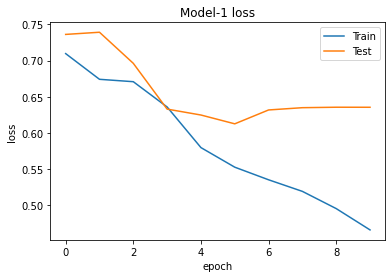

In [297]:
plot(history1.history['loss'], history1.history['val_loss'], 'Model-1 loss')

###### Model evaluate score

In [299]:
score = model.evaluate(padded_test, y_test, verbose=0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]) 

Test loss: 0.624801516532898
Test accuracy: 0.8029020428657532
